# QML for Data Scientists 
## Session 2: Quantum Support Vector Machines
Bryce Fuller, Quantum Applications Researcher - IBM

In [32]:
# General Imports
import numpy as np
import sklearn
from scipy.linalg import expm

from qiskit import Aer
from qiskit.aqua import QuantumInstance

# Circuit Imports
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap
from qiskit.circuit import Parameter

# Operator Imports
from qiskit.aqua.operators import I, Z, StateFn, CircuitStateFn, SummedOp
from qiskit.aqua.operators.gradients import NaturalGradient

# Algorithm Imports
from qiskit.aqua.algorithms.classifiers import VQC, QSVM

# Additional Imports
from qiskit.quantum_info import state_fidelity, partial_trace, Statevector
from qiskit.aqua.components.optimizers import SPSA, CG, ADAM, COBYLA
from qiskit.ml.datasets import ad_hoc_data, digits
from qiskit.aqua.utils import split_dataset_to_data_and_labels

# Import a Dataset (this one is synthetic data)

In [22]:
sample_total, training_dataset, test_dataset, class_labels = ad_hoc_data(100, 30, 2, 0.3)

# Variational Quantum Classifier
### Self contained implementation using qiskit

In [38]:
n_qubits = 2

Phi = ZZFeatureMap(n_qubits)
fixed_params = Phi.ordered_parameters



W = RealAmplitudes(2)
free_params = W.ordered_parameters





def get_param_binding(params, vals):
    return {param: vals[i] for i,param in enumerate(params)}

vals = [i+1 for i in range(len(free_params))] + [0 for elem in range(len(fixed_params))]
param_binds = get_param_binding(free_params+fixed_params, vals)

circuit = Phi.compose(W)

circuit.bind_parameters(param_binds).draw()
#"""


┌───┐┌───────┐                                  ┌───┐┌───────┐     »
q_0: ┤ H ├┤ U1(0) ├──■────────────────────────────■──┤ H ├┤ U1(0) ├──■──»
     ├───┤├───────┤┌─┴─┐┌──────────────────────┐┌─┴─┐├───┤├───────┤┌─┴─┐»
q_1: ┤ H ├┤ U1(0) ├┤ X ├┤ U1(19.7392088021787) ├┤ X ├┤ H ├┤ U1(0) ├┤ X ├»
     └───┘└───────┘└───┘└──────────────────────┘└───┘└───┘└───────┘└───┘»
«                                  ┌───────┐     ┌───────┐     ┌───────┐     »
«q_0: ──────────────────────────■──┤ RY(1) ├──■──┤ RY(3) ├──■──┤ RY(5) ├──■──»
«     ┌──────────────────────┐┌─┴─┐├───────┤┌─┴─┐├───────┤┌─┴─┐├───────┤┌─┴─┐»
«q_1: ┤ U1(19.7392088021787) ├┤ X ├┤ RY(2) ├┤ X ├┤ RY(4) ├┤ X ├┤ RY(6) ├┤ X ├»
«     └──────────────────────┘└───┘└───────┘└───┘└───────┘└───┘└───────┘└───┘»
«     ┌───────┐
«q_0: ┤ RY(7) ├
«     ├───────┤
«q_1: ┤ RY(8) ├
«     └───────┘

In [4]:
optimizer = SPSA()
backend = Aer.get_backend('statevector_simulator')
qi = QuantumInstance(backend=backend)

vqc = VQC(optimizer = optimizer, 
          feature_map = Phi, 
          var_form = W,
          training_dataset=training_dataset,
          test_dataset=test_dataset,
          quantum_instance=qi)

In [8]:
#svc_result = vqc.run()
svc_result

{'num_optimizer_evals': None, 
 'min_val': 0.3380228673931364, 
 'opt_params': array([-2.67801051, -3.67754291, 11.22994432, -5.51844612, -1.83415757, 
        -6.103766  , -1.09645855,  5.79320133]), 
 'eval_time': 2392.05264878273, 
 'eval_count': 2051, 
 'training_loss': 0.3380228673931364, 
 'testing_accuracy': 0.9333333333333333, 
 'test_success_ratio': 0.9333333333333333, 
 'testing_loss': 0.29446032406287265}


# Quantum Kernel Estimator
### Self-contained Qiskit implementation of QSVM (SVM + Quantum Kernel Estimator)

In [9]:

backend = Aer.get_backend('statevector_simulator')

quantum_instance = QuantumInstance(backend=backend)

qsvm = QSVM(feature_map=Phi, 
            training_dataset=training_dataset, 
            test_dataset=test_dataset)

result = qsvm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  1.0


# Realizing a QSVM with minimal qiskit code

### Manually extracting the Kernel Matrices

## $$ \Phi(\vec{x_j})\vert 0 \rangle =  \vert \Phi(\vec{x_j}) \rangle $$

#### In order to train our SVM, we will use k=200 data points. So, our kernel matrix will be (200,200)

## $$K_{i,j} = \left| \langle \Phi(\vec{x_i}) \vert \Phi(\vec{x_j})     \right|^2$$

#### In order to classify a new data point $s$, we will need to compute the kernel function with it and each data point. So for l = 60 new, data points, we will need to evaluate 200•60 kernel entries. 
## $$K(\vec{x_i},\vec{s}) = \left| \langle \Phi(\vec{x_i}) \vert \Phi(\vec{s})     \right|^2$$

In [10]:
# Get the MNIST pre-loaded dataset 
sample_total, training_dataset, test_dataset, class_labels = digits(100, 30, 2)



key1 = 'A'
key2 = 'B'

# Get the entries corresponding to 0 and 1
X_train, y_train = split_dataset_to_data_and_labels(training_dataset, {key1 : 1, key2 : -1})
X_test, y_test = split_dataset_to_data_and_labels(test_dataset, {key1 : 1, key2 : -1})

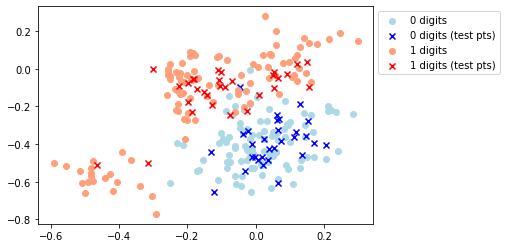

In [11]:
import matplotlib.pyplot as plt

plt.scatter(training_dataset[key1][:,0], 
            training_dataset[key1][:,1], 
            label='0 digits', color='lightblue')
plt.scatter(test_dataset[key1][:,0], 
            test_dataset[key1][:,1], 
            label='0 digits (test pts)', marker='x', color='blue')

plt.scatter(training_dataset[key2][:,0], 
            training_dataset[key2][:,1], 
            label='1 digits', color='lightsalmon')
plt.scatter(test_dataset[key2][:,0], 
            test_dataset[key2][:,1],  
            label='1 digits (test pts)', marker='x', color='red')

plt.legend(bbox_to_anchor=(1,1))

In [12]:
# Precompute this to train your SVM
K_train = QSVM.get_kernel_matrix(quantum_instance=qi,
                       feature_map=Phi,
                       x1_vec= X_train)

# Classify new points
K_test = QSVM.get_kernel_matrix(quantum_instance=qi,
                       feature_map=Phi,
                       x1_vec= X_train,
                       x2_vec= X_test)

print("K_train: ", K_train.shape)
print("K_test: ", K_test.shape)

K_train:  (200, 200)
K_test:  (200, 60)


In [28]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, roc_curve, auc
def get_auc(estimator, x_test, y_test):
    y_hat = estimator.predict_proba(x_test)
    y_hat = [i[1] for i in y_hat]
    return roc_auc_score(y_test,y_hat)

In [41]:
clf = sklearn.svm.SVC(kernel='precomputed', probability=True)
clf.fit(K_train, y_train)

# AUC found using predict_proba
train_auc = get_auc(clf, K_train, y_train)
test_auc = get_auc(clf,K_test.T, y_test)

# Balanced Accuracy
y_hat_test = clf.predict(K_test.T)
y_hat_train = clf.predict(K_train)
test_acc = balanced_accuracy_score(y_test, y_hat_test, adjusted=False)
train_acc = balanced_accuracy_score(y_train, y_hat_train, adjusted=False)

print('Balanced Accuracy: \t', test_acc)
print('AUC: \t\t\t',test_auc)

Balanced Accuracy: 	 0.8833333333333333
AUC: 			 0.9722222222222223


#  Compute a Meshgrid to Visualize Decision Boundary

### Retrain with only the support vectors.

When we go to predict new data with the model will try to compute the overlap with our whole dataset. 
By re-training with only the support vectors we can reduce the number of circuits that need to be run to compute a contour plot.

In [30]:
support = clf.support_

K_train_pruned = K_train[support,:][:,support]
K_test_pruned = K_test[support,:]
print("K_train: ", K_train_pruned.shape)
print("K_test: ", K_test_pruned.shape)

K_train:  (115, 115)
K_test:  (115, 60)


In [42]:
clf = sklearn.svm.SVC(kernel='precomputed', probability=True)
clf.fit(K_train_pruned, y_train[support])

# AUC found using predict_proba
train_auc = get_auc(clf, K_train_pruned, y_train[support])
test_auc = get_auc(clf,K_test_pruned.T, y_test)

# Balanced Accuracy
y_hat_test = clf.predict(K_test_pruned.T)
y_hat_train = clf.predict(K_train_pruned)
test_acc = balanced_accuracy_score(y_test, y_hat_test, adjusted=False)
train_acc = balanced_accuracy_score(y_train[support], y_hat_train, adjusted=False)

print('Balanced Accuracy: \t', test_acc)
print('AUC: \t\t\t',test_auc)

Balanced Accuracy: 	 0.8833333333333333
AUC: 			 0.9722222222222223


### Compute the Kernel for each point in the mesh 

In [42]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x
    y_min, y_max = y
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

# Set-up grid for plotting.
xx, yy = make_meshgrid((-0.7, 0.35), (-0.9,0.3))
mesh_pts = np.c_[xx.ravel(), yy.ravel()]

In [56]:
# Since we trained our SVM with a precomputed Kernel, we will also need to 
# Compute the kernel function for each of our points in the mesh. This can be 
# very expensive, and the SKlearn Classifier will expect the mesh/data kernel 
# to be of size (n_training_pts, n_mesh_pts). This is why I retrained the 
# classifier with only the support vectors. That should save us ~half the time.

K_mesh = QSVM.get_kernel_matrix(quantum_instance=qi,
       feature_map=Phi,
       x1_vec= X_train[support],
       x2_vec= mesh_pts)

K_mesh.shape

(115, 3180)

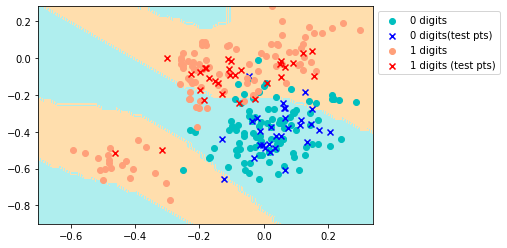

In [69]:
fig, ax = plt.subplots()
title = ('Decision surface of Quantum SVC ')
Z = clf.predict(K_mesh.T)
Z = Z.reshape(xx.shape)
out = ax.contourf(xx, yy, Z, colors=['navajowhite','paleturquoise'])

plt.scatter(training_dataset[key1][:,0], 
            training_dataset[key1][:,1], 
            label='0 digits', color='c')
plt.scatter(test_dataset[key1][:,0], 
            test_dataset[key1][:,1], 
            label='0 digits(test pts)', marker='x', color='blue')

plt.scatter(training_dataset[key2][:,0], 
            training_dataset[key2][:,1], 
            label='1 digits', color='lightsalmon')
plt.scatter(test_dataset[key2][:,0], 
            test_dataset[key2][:,1],  
            label='1 digits (test pts)', marker='x', color='red')

plt.legend(bbox_to_anchor=(1,1))